# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

*Note: The data given for this assignment is not the same as the data used in the article and as a result the visualizations may look a little different.*

<IPython.core.display.Javascript object>


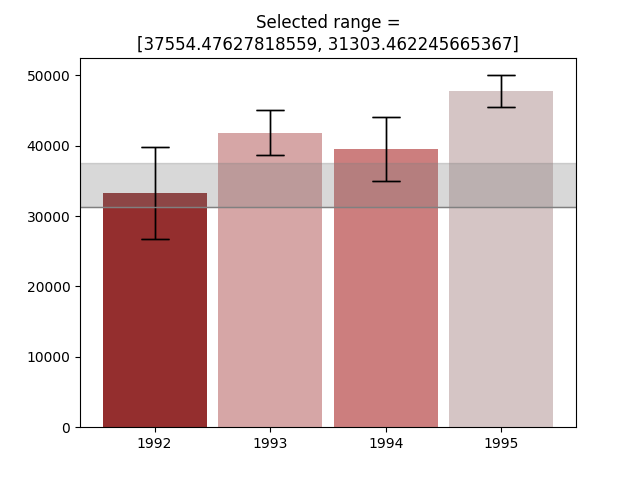

mean    39823.045494
mean    26801.169458
Name: 1992, dtype: float64
mean    45055.114385
mean    38668.604697
Name: 1993, dtype: float64
mean    44048.634533
mean    34937.975350
Name: 1994, dtype: float64
mean    50008.112260
mean    45478.989678
Name: 1995, dtype: float64


7

In [247]:
# Use the following data for this assignment:
%matplotlib notebook

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

def get_df(seed_no, index):
    np.random.seed(seed_no)

    df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                       np.random.normal(43000,100000,3650), 
                       np.random.normal(43500,140000,3650), 
                       np.random.normal(48000,70000,3650)], 
                      index=index)
    return df
    
def get_em95(df):
    
    df_de = df.describe()
    leng = len(df)
    
    # SEM = std. err. of the mean
    sem = stats.sem(df)
    
    # confidence interval = 95% = 0.95
    # calculate the t value
    t = -(stats.t.ppf((1-0.95)/2, leng-1))

    # error of the mean at 95% CI
    return (t * sem)

def plot():
    df = get_df(seed, index).T
    em95 = get_em95(df)
    fig, ax = plt.subplots()
    
    df_de = df.describe()
    err_range = pd.DataFrame([df_de.loc['mean']+em95, df_de.loc['mean']-em95])
    return fig, ax, df, err_range

def update(color = ['lightgray' for _ in range(4)]):
    ax.bar(range(1,5,1),
           [df[i].mean() for i in index],
           width=0.9,
           yerr=em95,
           error_kw=dict(ecolor='black', lw=1, capsize=10, capthick=1),
           color=color)
    plt.xticks(range(1,5,1), index)

seed = 12345
index = [1992,1993,1994,1995]
fig, ax, df, err_range = plot()
for item in err_range:
    print(err_range[item])

update()
plt.gca().set_title('Please click on the plot.')

click_count = 0

def onclick(event):
    plt.cla()
    update()
        
    global click_count
    global prev, level, y_range
    
    level = event.ydata
    plt.axhline(level, lw=1, c='gray')
    
    plt.gca().set_title('y = {}\nSelect a second point.'.format(event.ydata))
    
    if click_count == 0:
        click_count += 1
        
        # store the event.ydata
        prev = level
    else:
        y_range = pd.Series([prev, level])
        plt.gca().set_title('Selected range =\n[{}, {}]'.format(y_range[0], y_range[1]))
        click_count = 0
        recolor(y_range)
        plt.axhspan(prev, level, alpha=0.3, color='gray')

# do a t-test to check if selected range is similar to the 95%CI range of each mean 
def recolor(y_range):
    color = []
    for item in err_range:
        s, p = stats.ttest_ind(err_range[item], y_range)
        color.append(((1-p*0.5), 0.1, 0.1, p))
    
    update(color)
        
# tell mpl_connect we want to pass a 'button_press_event' into onclick when the event is detected
plt.gcf().canvas.mpl_connect('button_press_event', onclick)

In [ ]:
              1992          1993          1994          1995
mean  39823.045494  45055.114385  44048.634533  50008.112260
mean  26801.169458  38668.604697  34937.975350  45478.989678